<img src=https://d31uz8lwfmyn8g.cloudfront.net/Assets/logo-henry-white-lg.png><p>

## Análisis Exploratorio de Datos:

En este notebook se realiza un análisis de los datos contenidos en los dataframes de usuarios, reviews y juegos de Steam, a los fines de armar un **sistema de recomendación** de tipo **filtro colaborativo** a partir de descomposición UV.

In [2]:
# En primer lugar, se importan las librerías con las que vamos a trabajar:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')
sns.set()

In [3]:
# Se cargan los archivos con los que se trabajará:
df_games = pd.read_parquet('../steam_games.parquet')
df_reviews = pd.read_parquet('../user_reviews.parquet')
df_items = pd.read_parquet('../user_items_extended.parquet')

In [10]:
# Se combina el df de user_reviews con el de juegos:
df_rev_games = pd.merge(df_reviews,df_games, on = "item_id", how="inner")

# Se combina el df de user_items con el de juegos:
df_items_games = pd.merge(df_items,df_games, on = "item_id", how="inner")

En primer lugar, se observa la cantidad de juegos distintos que incluye el Data Frame:

In [4]:
# Chequeamos la cantidad de valores únicos en la columna "item_id":
print('Cantidad de juegos:', df_games["item_id"].nunique())

Cantidad de juegos: 22527


Luego observamos la cantidad de usuarios:

In [5]:
# Chequeamos la cantidad de valores únicos en la columna "user_id":
print('Cantidad de usuarios:', df_items["user_id"].nunique())

Cantidad de usuarios: 70912


Consultamos la cantidad de juegos lanzados por año:

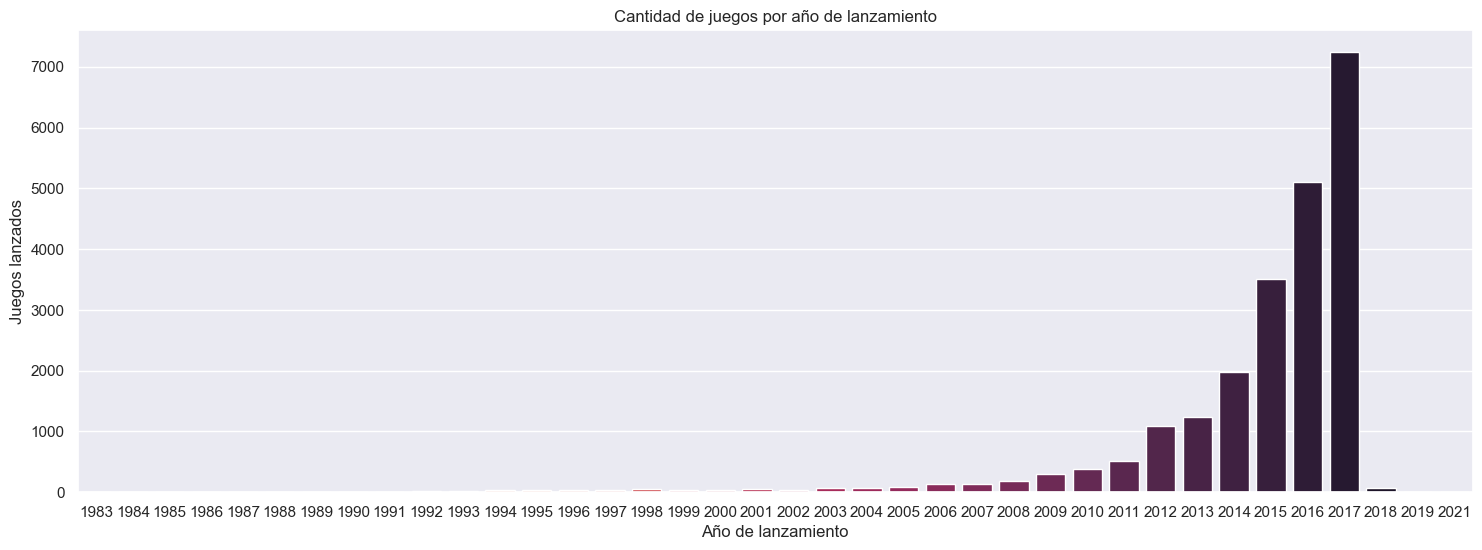

In [7]:
# Visualizamos
plt.figure(figsize=(18,6))
sns.countplot(data = df_games, x = "release_year", palette= "rocket_r")
plt.xticks(rotation=0)
plt.ylabel('Juegos lanzados')
plt.xlabel('Año de lanzamiento')
plt.title('Cantidad de juegos por año de lanzamiento')
plt.show()

Luego cuál es el **top 10** de juegos según cantidad de usuarios:

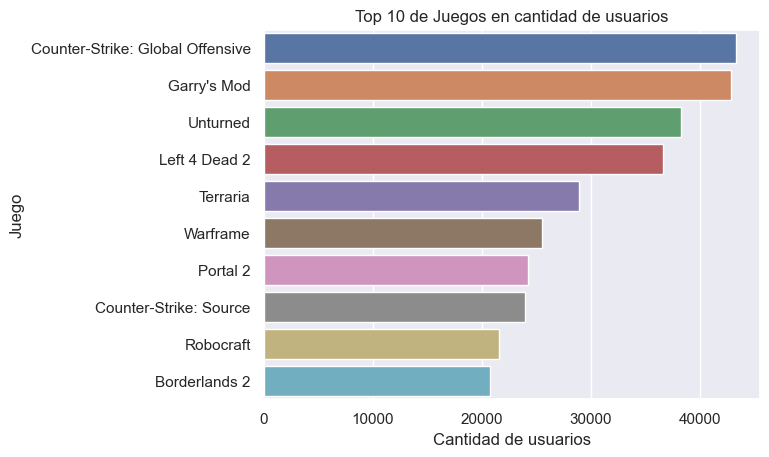

In [8]:
# Se calcula el top 10 de juegos con mayor cantidad de usuarios:
top_games_users = df_items_games.groupby("app_name")["user_id"].count().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = top_games_users, y = "app_name", x = "user_id")
plt.xticks(rotation=0)
plt.ylabel('Juego')
plt.xlabel('Cantidad de usuarios')
plt.title('Top 10 de Juegos en cantidad de usuarios')
plt.show()

Se calcula el **top 10** de **juegos** con **expresión de sentimiento positivo**:

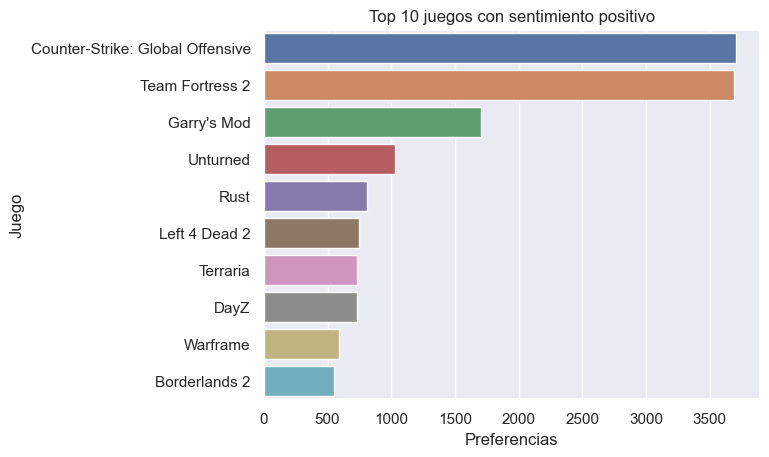

In [9]:
# Se calcula el top 10 de juegos con análisis de sentimiento positivo:
positive_reviews = df_rev_games[df_rev_games["sentiment_analysis"] == 2]
# Se agrupan por nombre de juego y se seleccionan los 10 con mas recomendaciones:
positive_reviews = df_rev_games.groupby("app_name")["sentiment_analysis"].count().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data= positive_reviews, y = "app_name", x = "sentiment_analysis")
plt.xticks(rotation=0)
plt.ylabel('Juego')
plt.xlabel('Preferencias')
plt.title('Top 10 juegos con sentimiento positivo')
plt.show()

Se calcula el top 10 de juegos recomendados:

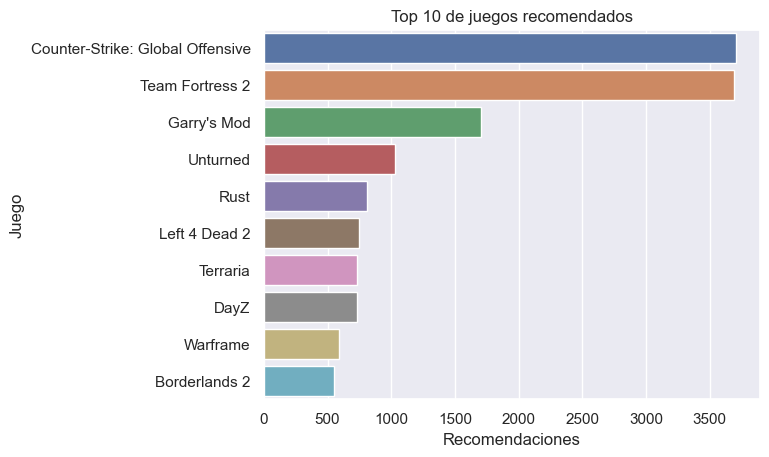

In [10]:
# Se filtran las recomendaciones de usuarios:
recommended_games = df_rev_games[df_rev_games["recommend"] == 1]
# Se agrupan por nombre de juego y se seleccionan los 10 con mas recomendaciones:
recommended_games = df_rev_games.groupby("app_name")["recommend"].count().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data= recommended_games, y = "app_name", x = "recommend")
plt.xticks(rotation=0)
plt.ylabel('Juego')
plt.xlabel('Recomendaciones')
plt.title('Top 10 de juegos recomendados')
plt.show()

Por otro lado, se calcula el **top 10** de juegos con más **horas jugadas en promedio**:

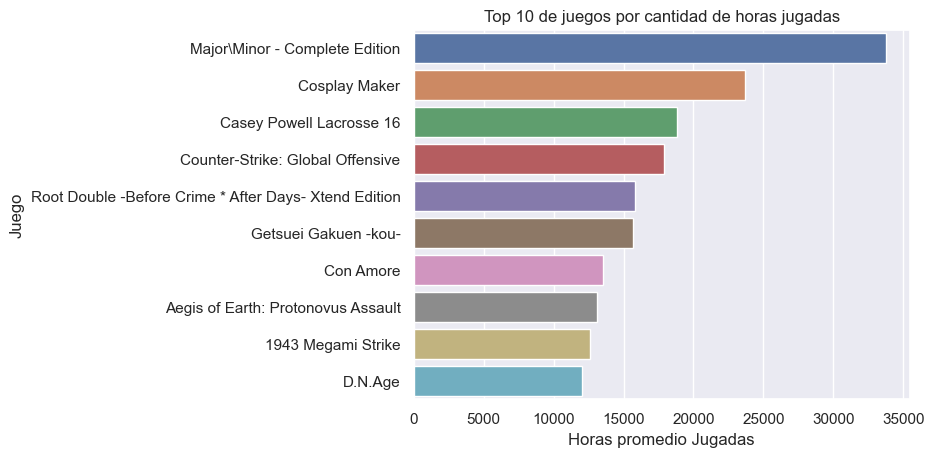

In [11]:
# Se agrupan por juego y se seleccionan los 10 con mas horas jugadas:
top_games_hours = df_items_games.groupby("app_name")["playtime_forever"].mean().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = top_games_hours, y = "app_name", x = "playtime_forever")
plt.ylabel('Juego')
plt.xlabel('Horas promedio Jugadas')
plt.title('Top 10 de juegos por cantidad de horas jugadas')
plt.show()

Comparamos fecha de lanzamiento:

In [12]:
# N° 1 del ranking
df_items_games[df_items_games["app_name"] == "Major\Minor - Complete Edition"]["release_year"].iloc[0]

2016

In [13]:
# N° 4 del ranking
df_items_games[df_items_games["app_name"] == "Counter-Strike: Global Offensive"]["release_year"].iloc[0]

2012

De acuerdo a lo expuesto anteriormente, podemos concluir que el juego **"Counter-Strike: Global Offensive"** es el juego con mayor cantidad de usuarios (más de la mitad del total), recomendaciones y reviews con expresión de sentimiento positivo. Cabe destacar que el nivel de reviews es muy bajo en comparación a la cantidad de usuarios del juego, representando para este caso en particular, menos del 10%.

No obstante, cabe destacar que el juego **"Major\Minor - Complete Edition"** es más nuevo, pero acumula mayor cantidad de horas jugadas en promedio.

Luego chequeamos la cantidad de reviews por "análisis de sentimiento":

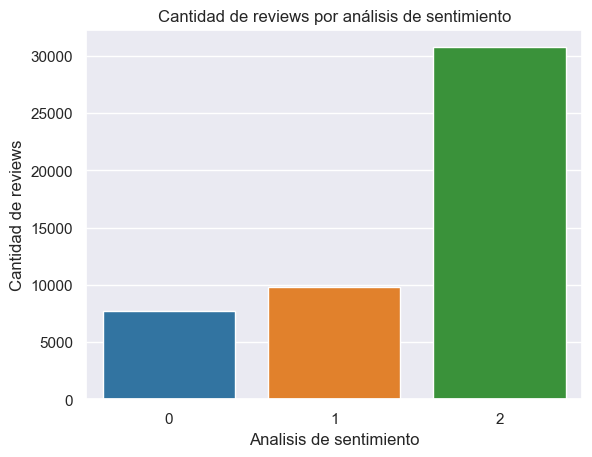

In [14]:
# Visualizamos
sns.countplot(data= df_reviews, x = "sentiment_analysis", palette= "tab10")
plt.xticks(rotation=0)
plt.ylabel('Cantidad de reviews')
plt.xlabel('Analisis de sentimiento')
plt.title('Cantidad de reviews por análisis de sentimiento')
plt.show()

Observamos que de las reviews realizadas, la mayoría fueron realizadas expresando un **sentimiento positivo** hacia el juego.

Por otro lado, analizamos el **top 10** de **usuarios** en **cantidad de reviews**:

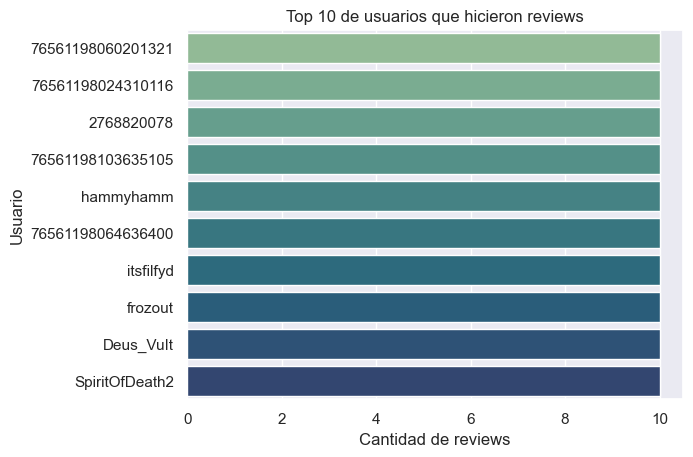

In [15]:
top_user_reviews = df_rev_games.groupby("user_id")["recommend"].count().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = top_user_reviews, y = "user_id", x = "recommend",palette="crest")
plt.xticks(rotation=0)
plt.xlabel('Cantidad de reviews')
plt.ylabel('Usuario')
plt.title('Top 10 de usuarios que hicieron reviews')
plt.show()

Como podemos ver, la cantidad máxima de reviews por usuario es de 10, por lo que se chequea los últimos 10 en caso de que exista la misma cantidad de reviews para todos los usuarios:

In [16]:
# Se analizan los últimos 10
df_rev_games.groupby("user_id")["recommend"].count().sort_values(ascending=False).tail(10)

user_id
MasterMindz          1
Masterhour           1
76561198070736657    1
76561198070735417    1
MatLyGames           1
MateusBeta           1
Matoota              1
76561198070728917    1
76561198070714959    1
--000--              1
Name: recommend, dtype: int64

Como podemos ver, hay usuarios que sólo han hecho una recomendación.

A continuación observamos el top 10 de usuarios con más horas jugadas:

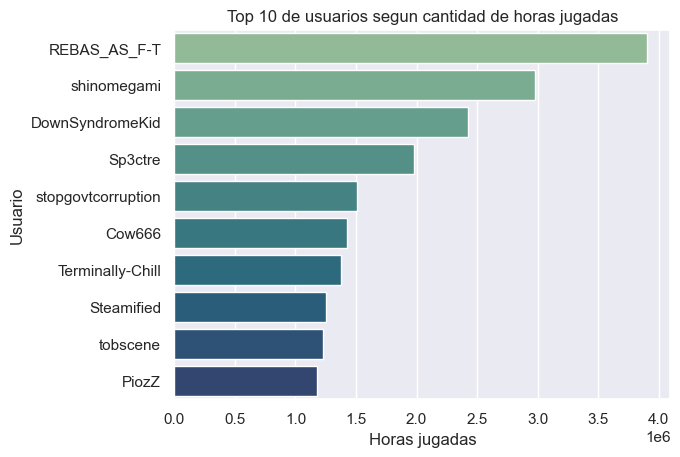

In [17]:
# Se agrupan la informacion por usuario y se suman las horas jugadas
top_user_hours = df_items_games.groupby("user_id")["playtime_forever"].sum().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = top_user_hours, x = "playtime_forever", y = "user_id", palette="crest")
plt.xlabel('Horas jugadas')
plt.ylabel('Usuario')
plt.title('Top 10 de usuarios segun cantidad de horas jugadas')
plt.show()

# Modelo de Machine Learning - Sistema de Recomendación:

A continuación se entrenará un modelo de Sistema de Recomendación de filtro colaborativo mediante el uso de la librería Surprise, por lo que en primer lugar importamos la librerías necesarias para trabajar:

In [6]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
import pickle

De acuerdo a lo consultado con la documentación del modelo, el mismo recibe como parámetros las siguientes variables:
    
    - Usuario
    - Item
    - Rating

In [4]:
# Filtramos las variables en el dataframe
df_RS = df_reviews[['user_id', 'item_id', 'sentiment_analysis']]
df_RS.shape

(48339, 3)

El modelo que se utilizará es el **"Singular Value Decomposition" (SVD)**, que es un algoritmo de factorización matricial que se utiliza para predecir calificaciones o preferencias de los usuarios para ciertos elementos, en función de calificaciones previas.

In [7]:
# Se instancia la clase "Reader()" de Surprise:
reader = Reader(rating_scale = (0,2))

# Se carga la data en la clase respectiva:
data = Dataset.load_from_df(df_RS, reader)

# Se separan los datos en los grupos de entrenamiento y prueba:
trainset, testset = train_test_split(data, test_size = 0.20)

# Instanciamos el modelo:
model = SVD()

# Entrenamos:
model.fit(trainset)

# Se predice sobre el grupo de prueba
predictions = model.test(testset)

Medimos el desempeño del modelo a través del RMSE:

In [8]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.7444


0.7444426150190886

Como la escala de la columna de análisis de sentimiento va de 0 a 2, un valor de RMSE cercano a 1 nos podría estar indicando cierta incapacidad del modelo para calificar correctamente a los items.

Por tal motivo, realizamos una **búsqueda** de los **mejores hiperparámetros** del modelo a través del método de búsqueda por grilla y utilizando validación cruzada, a los fines de obtener aquellos que nos den el **menor nivel de error**:

In [22]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)

# Se carga la data en la clase respectiva:
data = Dataset.load_from_df(df_RS, reader)

# Se entrena el modelo sobre el grupo de entrenamiento:
gs.fit(data)

print("Mejores hiperparámetros: "+str(gs.best_params['rmse']))
print("Mejor Score: "+str(gs.best_score['rmse'])+'\n')

Mejores hiperparámetros: {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
Mejor Score: 0.7433787710896516



Por último, se configura el modelo con los mejores hiperparámetros obtenidos anteriormente:

In [9]:
# Instanciamos el modelo:
model1 = SVD(n_factors = 5, n_epochs = 20, lr_all = 0.005, reg_all = 0.2)

# Entrenamos:
model1.fit(trainset)

# Se predice sobre el grupo de prueba
predictions1 = model1.test(testset)

# Evaluamos:
accuracy.rmse(predictions1)

RMSE: 0.7372


0.7371886226459751

Guardamos el modelo entrenado en un archivo pkl:

In [10]:
with open('RS_model.pkl', 'wb') as file:
    pickle.dump(model1, file)

## Endpoint API:

A continuación se crea la función que permitirá obtener, a partir de un id de usuario, una lista con 5 recomendaciones de juegos para el mismo:

In [7]:
def user_recommendations(user_id):
    '''
    Devuelve una lista con 5 recomendaciones de juegos para el usuario ingresado.
  
    Ejemplo de retorno: {'Recomendaciones para el usuario 76561197970982479': ['1. RWBY: Grimm Eclipse',
  '2. Rogue Legacy',
  '3. Dust: An Elysian Tail',
  "4. King Arthur's Gold",
  '5. RIFT']} 
    '''
    # Si el user_id no se encuentra en los dataframes:
    if user_id not in df_reviews['user_id'].values:
        
        return f"ERROR: El user_id {user_id} no existe en la base de datos."   # se imprime mensaje de error
    
    else:
      # Se asigna el id ingresado a la variable user
      user = user_id

      # En primer lugar, sacamos los juegos que el usuario ya ha jugado:
      df_rev_games = pd.merge(df_reviews,df_games, on = "item_id", how="inner")
      games_played = df_rev_games[df_rev_games['user_id'] == user]

      # Se eliminan del df de juegos los jugados por el usuario
      df_user = df_games[["item_id", "app_name"]].drop(games_played.item_id, errors='ignore')

      # Cargamos el modelo de Sistema de Recomendación entrenado:
      with open('RS_model.pkl', 'rb') as file:
          RS_model = pickle.load(file)

      # Realizamos las predicciones y las agregamos en una nueva columna:
      df_user['estimate_Score'] = df_user['item_id'].apply(lambda x: RS_model.predict(user, x).est)

      # Ordenamos el df de manera descendente en funcion al score y seleccionamos los 5 principales:
      recommendations = df_user.sort_values('estimate_Score', ascending=False)["app_name"].head(5).to_list()

      # Se crea la llave del diccionario de retorno
      llave_dic = f'Recomendaciones para el usuario {user}'

      # Se da formato al top 5 de recomendaciones:
      recomm_output = [f'1. {recommendations[0]}', f'2. {recommendations[1]}', f'3. {recommendations[2]}', f'4. {recommendations[3]}',f'5. {recommendations[4]}']
      
      # Se devuelven los resultados en un diccionario
      return {llave_dic : recomm_output}

In [13]:
# Se prueba la funcion
user_recommendations("76561197970982479")

{'Recomendaciones para el usuario 76561197970982479': ["1. King Arthur's Gold",
  '2. Mass Effect 2',
  '3. Rogue Legacy',
  '4. FEZ',
  '5. RIFT']}